[View in Colaboratory](https://colab.research.google.com/github/vbipin/nlp/blob/master/pytorch_nmt_with_attn.ipynb)

In [1]:
### !pip3 install torch

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#This notebook is adapted from
##http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
#for monitoring
from time import time
#for parsing the data filename
import re

In [6]:
#here we prepare data directly form the web link. It is useful in Colab notebooks
#to convert to script
#jupyter nbconvert --to script [YOUR_NOTEBOOK].ipynb

In [7]:
#we need the data from : http://www.manythings.org/anki/fra-eng.zip
import requests
import gzip
import io
import zipfile

#get the contents from the website
"""r = requests.get('http://www.manythings.org/anki/fra-eng.zip')"""

#this is one ugly code; But I need the text from a zip file in a url :(((
#https://stackoverflow.com/questions/37704836/how-do-i-read-a-csv-file-thats-gzipped-from-url-python
#https://codeyarns.com/2013/10/03/how-to-read-contents-of-zip-file-in-python/
#https://docs.python.org/2/library/zipfile.html
"""
with zipfile.ZipFile( io.BytesIO(r.content), mode='r' ) as zip_file :
  print (zip_file.namelist())
  lines = zip_file.read('fra.txt').strip().split(b'\n')
  lines = [ str(l, 'utf-8') for l in lines ]
  print(len(lines))
"""
;

''

In [8]:
#if we have the lines form a file; create it here.

In [116]:
#This class is from the pytorch tutorial. 
#it holds thevocab and index convertions

#XXX TODO: May be use torchtext

UNK_token = 0
PAD_token = 1
SOS_token = 2
EOS_token = 3

class Lang:
    def __init__(self, name):
        self.name = name
        self.stoi = {"<unk>":UNK_token, "<pad>":PAD_token, "<sos>" :SOS_token, "<eos>" :EOS_token}
        self.itos = {UNK_token:"<unk>", PAD_token:"<pad>", SOS_token: "<sos>", EOS_token: "<eos>"}
        self.n_words = len(self.stoi)  # Count SOS and EOS
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.word2count = {}
        self.vocab = self.stoi

    def add_line(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.stoi:
            self.stoi[word] = self.n_words
            self.word2count[word] = 1
            self.itos[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    

In [10]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalize_string(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)     #add a space
    s = re.sub(r"[^a-zA-Z.!?']+", r" ", s) #only these; others are spaces
    return s

In [117]:
import re
#m = re.search( '(...)-(...)\.txt', 'eng-fra.txt')
#m.group(2)
class Data__ :
    def __init__(self, src_lines, trg_lines,max_len=35, n_data=None ) :
        
        if n_data : #we only consider that many lines  
            self.src_lines = src_lines[0:n_data]
            self.trg_lines = trg_lines[0:n_data]
        else :
            self.src_lines = src_lines
            self.trg_lines = trg_lines
            
        self.src_lang = Lang('src') #for each language counts etc
        self.trg_lang = Lang('trg')
        #self.src_lang = src_lang #for each language counts etc
        #self.trg_lang = trg_lang
        
        for s in self.src_lines :
            self.src_lang.add_line(s)
            
        for t in self.trg_lines :
            self.trg_lang.add_line(t)
            
        #self.seq_len = 1
        self.batch_size = 1
        self.max_len = max_len
        
        #to tensor
        self.src_tensors = torch.stack( [ self.line_to_tensor(self.src_lang, s) for s in self.src_lines ] ).to(device)
        self.trg_tensors = torch.stack( [ self.line_to_tensor(self.trg_lang, t) for t in self.trg_lines ] ).to(device)
        
        
    def word_to_tensor(self, word, lang=None ) :
        if not lang :
            lang = self.trg_lang
        return torch.LongTensor( [lang.stoi[word]] ).view(-1,1).to(device)
    
    def index_to_tensor(self, index) :
        return torch.LongTensor( [index] ).view(-1,1).to(device)
        
    def line_to_tensor(self, lang, sentence):
        idxs = [lang.stoi[word] for word in sentence.split(' ')]
        #idxs.append( lang.EOS_token ) # this is the EOS token
        length = len(idxs)
        extend = self.max_len - length - 1 #we take out the lebth and start token and extend that much EOS token
        idxs = [lang.SOS_token] + idxs + [lang.EOS_token] * extend
        return torch.LongTensor(idxs)
            
    def train_batch(self, n_data=1000, random=True) : #we return the torchtensor inputs to embedding layers
        N = len(self.src_lines)
        r_indexs = np.random.randint(N, size=n_data)
        for i in r_indexs :
            yield self.src_tensors[i].view(-1,1 ), self.trg_tensors[i].view(-1,1 )
            #yield st.to(device), dt.to(device)
            
    def batch__(self, batch_size=1) : #we return the torchtensor inputs to embedding layers
        for s,d in self.pairs : 
            st = self.line_to_tensor(self.src,  s).view(-1,1 ) #seq_length, index (n,1)
            dt = self.line_to_tensor(self.dest, d).view(-1,1 )#batch need to be handled later
            yield st.to(device), dt.to(device)
    
    def batch_(self, n_data=1000, random=True) : #we return the torchtensor inputs to embedding layers
        #first we create n_size random indexes for 0 to N
        N = len(self.pairs)
        r_indexs = np.random.randint(N, size=n_data)
        for i in r_indexs :
            s,d = self.pairs[i] 
            st = self.line_to_tensor(self.src,  s).view(-1,1 ) #seq_length, index (n,1)
            dt = self.line_to_tensor(self.dest, d).view(-1,1 )#batch need to be handled later
            yield st.to(device), dt.to(device)


In [12]:
#from: https://github.com/pytorch/text/blob/master/test/translation.py
"""

import re
import spacy

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

url = re.compile('(<url>.*</url>)')


def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(url.sub('@URL@', text))]


def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(url.sub('@URL@', text))]
    
    
# Testing custom paths
DE = data.Field(tokenize=tokenize_de)
EN = data.Field(tokenize=tokenize_en)

train, val = datasets.TranslationDataset.splits(
    path='.data/multi30k/', train='train',
    validation='val', exts=('.de', '.en'),
    fields=(DE, EN))

print(train.fields)
print(len(train))
print(vars(train[0]))
print(vars(train[100]))

DE.build_vocab(train.src, min_freq=3)
EN.build_vocab(train.trg, max_size=50000)

train_iter, val_iter = data.BucketIterator.splits(
    (train, val), batch_size=3)

print(DE.vocab.freqs.most_common(10))
print(len(DE.vocab))
print(EN.vocab.freqs.most_common(10))
print(len(EN.vocab))

batch = next(iter(train_iter))
print(batch.src)
print(batch.trg)
"""
;

''

In [193]:
#Data class usnign torchtext
import re
import spacy

from torchtext import datasets
from torchtext import data
from torchtext.data import Field

spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

url = re.compile('(<url>.*</url>)')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(url.sub('@URL@', text))]


def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(url.sub('@URL@', text))]

class Data :
    def __init__(self) :
        DE = data.Field(tokenize=tokenize_de, init_token="<sos>", eos_token="<eos>" )
        EN = data.Field(tokenize=tokenize_en, init_token="<sos>", eos_token="<eos>" )
        self.train, self.val,self.test = datasets.TranslationDataset.splits(
                path='data/multi30k/', train='train',
                validation='val', exts=('.de', '.en'),
                fields=(DE, EN))
        DE.build_vocab(self.train.src,  min_freq=3) #specials=['<sos>','<eos>','<unk>','<pad>'],
        EN.build_vocab(self.train.trg,  max_size=50000) #specials=['<sos>','<eos>','<unk>','<pad>'],
        
        self.src_lang = DE
        self.trg_lang = EN


    def train_batch(self, batch_size=1) :
        #train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=batch_size)
        #bi = data.BucketIterator.splits((self.val,), batch_size=batch_size)
        bi = data.BucketIterator.splits((self.train,), batch_size=batch_size)
        train_iter = next(iter(bi))
        for batch in train_iter :
            yield batch.src, batch.trg
        
    def val_batch(self, batch_size=1) :
        #train_iter, val_iter = data.BucketIterator.splits((train, val), batch_size=batch_size)
        bi = data.BucketIterator.splits((self.val,), batch_size=batch_size)
        val_iter = next(iter(bi))
        for batch in val_iter :
            yield batch.src, batch.trg    
        
        

In [14]:
lines_de = open("data/multi30k/val.de", encoding='utf-8').read().strip().split('\n')
lines_en = open("data/multi30k/val.en", encoding='utf-8').read().strip().split('\n')

In [15]:
#lines = [ (normalize_string(lines_de[i]), normalize_string(lines_en[i])) for i in range(len(lines_de)) ]
#len(lines)

In [194]:
#German to English
#multi30k_data__ = Data__(lines_de, lines_en, max_len=35 )
multi30k_data = Data()
#print(random.choice(data.pairs))

In [120]:
multi30k_data__ = Data__(lines_de, lines_en, max_len=35 )

In [33]:
#French to English
#data = Data( lines, 'eng', 'fra', reverse=True, n_data=10000 )
#print(random.choice(data.pairs))

In [34]:
##################################################################

In [33]:
class EncoderRNN(nn.Module):
    def __init__(self, src_vocab_size, hidden_size, num_layers=1 ):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        #embedding vector size is fixed as hidden size
        self.enbedding_vector_size = hidden_size
        self.embedding = nn.Embedding(src_vocab_size, self.enbedding_vector_size )
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(-1)
        output = embedded.view( input.shape[0], 1, -1 ) #seq_length, batch, enbbding
        #print (output.shape)
        #print (hidden.shape)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [34]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, dest_vocab_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        #embedding vector size is fixed as hidden size
        self.enbedding_vector_size = hidden_size
        self.embedding = nn.Embedding(dest_vocab_size, self.enbedding_vector_size )
        
        self.gru = nn.GRU(hidden_size, hidden_size)
        
        self.linear = nn.Linear(hidden_size, dest_vocab_size)
        #self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(-1)
        #output = F.relu(output)
        output = embedded.view( input.shape[0], 1, -1 ) #input shape[0] is 1 as wqe feed one input at a time.
        
        output, hidden = self.gru(output, hidden)
        output = self.linear( output.squeeze() )
        #print (output.shape)
        output = F.log_softmax( output, dim=0 )
        return output.view(1,-1), hidden #output of shape N,C; here N=1

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [35]:
MAX_LENGTH = 35

class Attn(nn.Module) :
    def __init__(self, hidden_size, max_length) :
        super(Attn, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length
        self.linear = nn.Linear(self.hidden_size, self.max_length)
        
        
    def forward(self, hidden, encoder_outputs) :
        
        attn_scores = self.linear(hidden)
        #print("attn_scores", attn_scores.shape )
                
        attn_weights = F.softmax(attn_scores, dim=2)
        
        #print("attn_weights", attn_weights.shape)
        #print("encoder_outputs",encoder_outputs.shape)
        
        attn_applied = torch.matmul(attn_weights.squeeze(),encoder_outputs)
        #print ("attn_applied ", attn_applied.shape)
        
        return attn_applied, attn_weights
        
        
        
        
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        #embedding vector size is fixed as hidden size
        self.enbedding_vector_size = hidden_size

        self.embedding = nn.Embedding(self.output_size, self.enbedding_vector_size)
        
        self.attn = Attn(self.hidden_size, self.max_length)
        #self.attn = nn.Linear(self.hidden_size, self.max_length)        
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        #self.dropout = nn.Dropout(self.dropout_p)
        
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        """input is an index of the word. We create a word vector out of it"""
        embedded = self.embedding(input) 
        #print("embedded", embedded.shape )
                
        """ gru hidden has shape (num_layers * num_dir, batch, hidden_size)
            Here first two dim are 1
        """
        output, hidden = self.gru(embedded.view(1,1,-1), hidden)
        #print ("hidden ", hidden.shape)
        
        #linear W.h 
        #out (max, )
        attn_context, attn_weights = self.attn( hidden, encoder_outputs)
        #print ("attn_context ", attn_context.shape)
        
        
        output = torch.cat((hidden.view(1,-1), attn_context.view(1,-1)), 1)
        #print ("output ", output.shape) 
        
        output = self.attn_combine(output)
        #print ("output ", output.shape)        
        output = F.relu(output) #h tilde
        #print ("output ", output.shape)
        
        #output = F.log_softmax(self.out(output), dim=1)
        output = self.out(output)
        #print ("output ", output.shape)
        
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [99]:
#debug_list = []
def translate( encoder, decoder, in_data, input_sentence ) :
    debug_list = [] #XXX
    x = in_data.line_to_tensor( in_data.src_lang, input_sentence ).to(device)
    h = encoder.initHidden().to(device)
    out, h = encoder(x, h)
    g = h
    
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
    for i in range(out.shape[0]) :
        encoder_outputs[i] = out[i][0]
        
    #first input is SOS
    next_word = in_data.index_to_tensor( in_data.trg_lang.SOS_token ).to(device)
    predicted_target = []
    for _ in range(25) :        
        scores, g, attn_w = decoder( next_word, g, encoder_outputs )
        #debug_list.append(attn_w)
        if next_word.item() == in_data.trg_lang.EOS_token :
            break
        predicted_target.append( next_word.item() )
        #now we make the next_word from current_word
        v, next_word = scores.topk(1) #return value and index
        #new_word = data.index_to_tensor( next_word )
        #next_word = torch.multinomial( torch.exp(scores), 1 )[0]
        #next_word = torch.multinomial( scores, 1 )[0]
        
        
    return " ".join([ in_data.trg_lang.itos[i] for i in predicted_target ])

In [69]:
MAX_LENGTH = 35
def train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, n_data=1000 ) :
    start = time()
    #batch = multi30k_data.batch(n_data=n_data, random=True)
    train_iter = multi30k_data.train_batch()
    
    loss_db = []
    for x, y in train_iter :
        loss = 0
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        h = encoder.initHidden().to(device)
        h.detach_()

        out, h = encoder(x, h)
        g = h

        encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
        for i in range(out.shape[0]) :
            encoder_outputs[i] = out[i][0]
    
        for i in range(len(y) - 1) :
        #for i in range(1) :
            scores, g, attn_w = decoder( y[i], g, encoder_outputs )
            #print(scores.shape)
            #print(next_word.shape)
            
            loss += criterion(scores, y[i+1] )
            #next_word = sample_from_scores( scores )  
            #next_word = sample_from_softmax( scores )

            #next_word = data.index_to_tensor( next_word )

        loss.backward()
        loss_db.append( float(loss) )
        
        decoder_optimizer.step()
        encoder_optimizer.step()
        if n_data < 0 :
            break
        else :
            n_data -= 1
        
    end = time()
    print (end-start)
    return loss_db

In [195]:
hidden_size = 256
encoder = EncoderRNN(len(multi30k_data.src_lang.vocab), hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, len(multi30k_data.trg_lang.vocab) ).to(device)

print(encoder)
print(decoder)



EncoderRNN(
  (embedding): Embedding(5499, 256)
  (gru): GRU(256, 256)
)
AttnDecoderRNN(
  (embedding): Embedding(10839, 256)
  (attn): Attn(
    (linear): Linear(in_features=256, out_features=35, bias=True)
  )
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=10839, bias=True)
)


In [196]:
learning_rate = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
#criterion = nn.NLLLoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [201]:
avg_loss = []
for _ in range(5) :
    l = train(encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, n_data=1000 )
    avg_loss.append( np.mean(l))

52.74745011329651
52.19828486442566
52.37849283218384
52.70231246948242
51.98996901512146


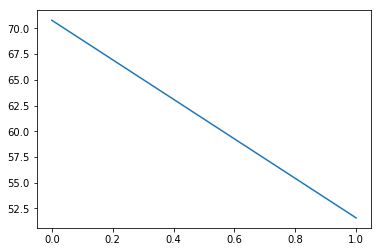

In [198]:
plt.plot(avg_loss)

In [200]:
i = 188
#input_sentence  = multi30k_data.src_lines[i]
#input_sentence  = lines_de[i]

#inp = 

#train_iter = multi30k_data.train_batch()
inp, out = next(train_iter)
target_output   = " ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in out ]) 
tout = translate2( encoder, decoder, inp )

output_sentence = " ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in tout ])
print(target_output)
#print(multi30k_data__.trg_lines[i])
print(output_sentence)

<sos> A woman singing into a microphone while a man plays drums in the background . <eos>
<sos> A woman in a black shirt is standing on a city street . <eos> <eos> <eos> . <eos> <eos> <eos> . <eos> <eos> <eos>


In [183]:
" ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in output_sentence ])

'<sos> A man dressed in <unk> holding the puck . <eos> <eos> <eos> <eos> <eos> a red with her party . <eos> <eos> <eos> <eos>'

In [180]:
train_iter = multi30k_data.train_batch()
inp, out = next(train_iter)

In [179]:
inp = multi30k_data.src_lang.numericalize( input_sentence.split(" ") )
inp

ValueError: expected sequence of length 4 at dim 1 (got 10)

In [181]:
" ".join([ multi30k_data.trg_lang.vocab.itos[i] for i in out ])

'<sos> A man wearing olive drab clothing is holding himself up off the ground with his hands . <eos>'

In [158]:
#debug_list = []
def translate2( encoder, decoder, x ) :
    debug_list = [] #XXX
    x = x.to(device)
    h = encoder.initHidden().to(device)
    out, h = encoder(x, h)
    g = h
    
    encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
    for i in range(out.shape[0]) :
        encoder_outputs[i] = out[i][0]
        
    #first input is SOS
    #next_word = in_data.index_to_tensor( in_data.trg_lang.SOS_token ).to(device)
    next_word = x[0]
    predicted_target = []
    for _ in range(25) :        
        scores, g, attn_w = decoder( next_word, g, encoder_outputs )
        #debug_list.append(attn_w)
        #if next_word.item() == in_data.trg_lang.EOS_token :
        #    break
        predicted_target.append( next_word.item() )
        #now we make the next_word from current_word
        v, next_word = scores.topk(1) #return value and index
        #new_word = data.index_to_tensor( next_word )
        #next_word = torch.multinomial( torch.exp(scores), 1 )[0]
        #next_word = torch.multinomial( scores, 1 )[0]
        
    return predicted_target    
    #return " ".join([ in_data.trg_lang.itos[i] for i in predicted_target ])